# transversity-combined

In [1]:
import sys,os
os.chdir('../../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from resman import RESMAN
import nest
import obslib.moments.moments

In [2]:
best1=4 # from only sidis run
best2=4 # from sidis+lattice run

## setup

In [3]:
class RUN:
    
    def __init__(self,path,nestfile,inputfile):
        self.conf=conf=load_config('%s/%s'%(path,inputfile))
        self.resman=RESMAN(self.conf);
        self.parman=self.resman.conf['parman']
        nest=load('%s/%s'%(path,nestfile))
        wmax=np.amax(nest['weights'])
        wmin_cut=wmax*1e-7
        self.weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.weights/=np.sum(self.weights)
        self.moments=obslib.moments.moments.MOMENTS(self.conf)
        self.nest=nest

In [4]:
path='outputs/transversity/transversity-0-v0/'
nestfile='nest%d'%best1
inputfile='transversity-0.py'
run1=RUN(path,nestfile,inputfile)

loading sidis data sets 3013

In [5]:
path='outputs/transversity/transversity-lattice-0-v0/'
nestfile='nest%d'%best2
inputfile='transversity-lattice-0.py'
run2=RUN(path,nestfile,inputfile)

loading moments data sets 1000

In [6]:
print 'run1 LogZ =',run1.nest['logz'][-1]
print 'run2 LogZ =',run2.nest['logz'][-1]

run1 LogZ = 43.8248465253
run2 LogZ = 41.7693338308


In [7]:
def get_kinematics():
    tabs=run1.resman.sidisres.tabs
    X,Z,Q2,pT=[],[],[],[]
    for k in tabs:X=np.append(tabs[k]['x'],X)
    for k in tabs:Z=np.append(tabs[k]['z'],Z)
    for k in tabs:Q2=np.append(tabs[k]['Q2'],Q2)
    for k in tabs:pT=np.append(tabs[k]['pT'],pT)
    return {'X':X,'Z':Z,'Q2':Q2,'pT':pT}
kin=get_kinematics()

## parameters

In [8]:
def plot_params(k,kk):
    order=run1.parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    for i in range(len(kk)):
        ax=py.subplot(nrows,ncols,i+1)
        par1=np.transpose(run1.samples)[get_idx(kk[i])]
        par2=np.transpose(run2.samples)[get_idx(kk[i])]
        pmin=run1.conf['params'][k][kk[i]]['min']
        pmax=run1.conf['params'][k][kk[i]]['max']
        R=(pmin,pmax)
        ax.hist(par1,histtype='stepfilled',range=R,weights=run1.weights,bins=10,facecolor='Yellow',edgecolor='k')
        ax.hist(par2,histtype='stepfilled',range=R,weights=run2.weights,bins=10,facecolor='none',edgecolor='r',hatch='...')
        ax.set_xlim(pmin,pmax)
        ax.set_title('%s-%s'%(k,kk[i]))
    py.tight_layout()


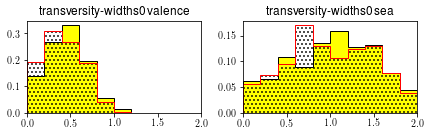

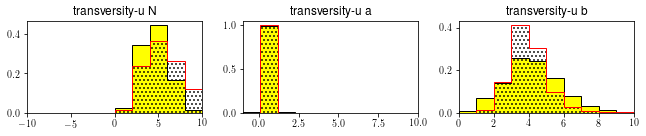

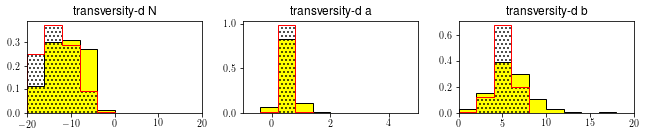

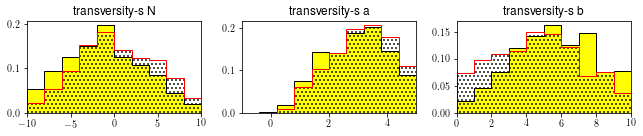

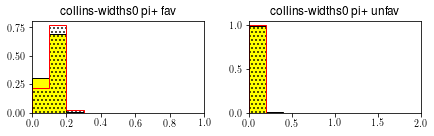

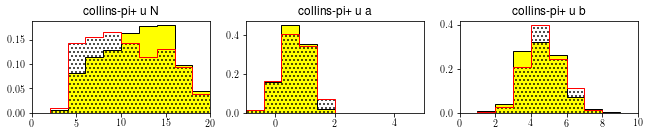

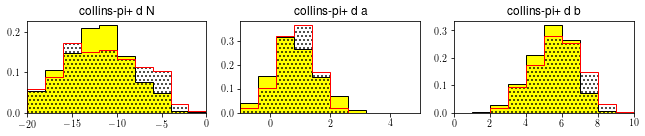

In [9]:
plot_params('transversity',['widths0 valence','widths0 sea'])
plot_params('transversity',['u N','u a','u b'])
plot_params('transversity',['d N','d a','d b'])
plot_params('transversity',['s N','s a','s b'])
plot_params('collins',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_params('collins',['pi+ u N','pi+ u a','pi+ u b'])
plot_params('collins',['pi+ d N','pi+ d a','pi+ d b'])
# plot_params('collins',['widths0 k+ fav','widths0 k+ unfav'])
# plot_params('collins',['k+ u N','k+ u a','k+ u b'])
# plot_params('collins',['k+ d N','k+ d a','k+ d b'])

## Data vs Theory

In [10]:
RAW1=load('outputs/transversity/transversity-0-v0/raw%d'%best1)
RAW2=load('outputs/transversity/transversity-lattice-0-v0/raw%d'%best2)

In [11]:
def process_raw(run,RAW):
    RES=RAW['RES']
    THY=RAW['THY']
    for k in RES:
        if k=='sidis': 
            for kk in RES[k]: 
                thy =np.einsum('k,ki',run.weights,np.array(THY[k][kk]))
                dthy=np.einsum('k,ki',run.weights,(np.array(THY[k][kk])-thy)**2)**0.5
                residuals=np.einsum('k,ki',run.weights,RES[k][kk])
                run.resman.sidisres.tabs[kk]['thy']=thy
                run.resman.sidisres.tabs[kk]['dthy']=dthy
                run.resman.sidisres.tabs[kk]['residuals']=residuals
                run.resman.sidisres.tabs[kk]['chi2']=residuals**2
                run.resman.sidisres.tabs[kk]=pd.DataFrame(run.resman.sidisres.tabs[kk])
        if k=='moments':
            for kk in RES[k]: 
                thy =np.einsum('k,ki',run.weights,np.array(THY[k][kk]))
                dthy=np.einsum('k,ki',run.weights,(np.array(THY[k][kk])-thy)**2)**0.5
                residuals=np.einsum('k,ki',run.weights,RES[k][kk])
                run.resman.momres.tabs[kk]['thy']=thy
                run.resman.momres.tabs[kk]['dthy']=dthy
                run.resman.momres.tabs[kk]['residuals']=residuals
                run.resman.momres.tabs[kk]['chi2']=residuals**2
                run.resman.momres.tabs[kk]=pd.DataFrame(run.resman.momres.tabs[kk])

In [12]:
process_raw(run1,RAW1)
process_raw(run2,RAW2)

In [13]:
pd.options.display.float_format = '{:,.1f}'.format

In [14]:
RES1=RAW1['RES']
RES2=RAW2['RES']
NPTS=0
CHI21=0
CHI22=0
D={}
for k in ['had','tar','dep','col','chi2','npts','chi2(+lattice)']: D[k]=[]
for k in RES1:
    for kk in RES1[k]:
        if k=='sidis':
            D['tar'].append(run1.resman.sidisres.tabs[kk]['target'].values[0])
            D['dep'].append(run1.resman.sidisres.tabs[kk]['dependence'].values[0])
            D['col'].append(run1.resman.sidisres.tabs[kk]['col'].values[0].upper().strip())
            D['had'].append(run1.resman.sidisres.tabs[kk]['hadron'].values[0])
            D['chi2'].append(np.sum(run1.resman.sidisres.tabs[kk]['chi2']))
            D['chi2(+lattice)'].append(np.sum(run2.resman.sidisres.tabs[kk]['chi2']))
            D['npts'].append(run1.resman.sidisres.tabs[kk]['value'].size)
D=pd.DataFrame(D)
D = D[['col', 'tar', 'had', 'dep', 'npts','chi2','chi2(+lattice)']]
D=D.sort_values(by=['col','tar'])
print D.to_string(index=False)
print '\nNtot =',np.sum(D.npts)
print 'Chi2tot =',np.sum(D.chi2)
print 'Chi2tot(+lattice) =',np.sum(D['chi2(+lattice)'])

col       tar  had dep  npts  chi2  chi2(+lattice)
COMPASS  deuteron  pi+   x     6   1.9             2.0
COMPASS  deuteron  pi+  pT     6   3.9             3.9
COMPASS  deuteron  pi+   z     6   1.8             1.8
COMPASS  deuteron  pi-   x     6   3.2             3.2
COMPASS  deuteron  pi-  pT     6   5.7             5.6
COMPASS  deuteron  pi-   z     6   6.3             6.4
COMPASS    proton  pi+   z     6   1.5             1.6
COMPASS    proton  pi+   x     7   5.7             5.6
COMPASS    proton  pi+  pt     6   2.6             2.5
COMPASS    proton  pi-  pt     6   1.0             1.0
COMPASS    proton  pi-   x     7   3.1             3.2
COMPASS    proton  pi-   z     6   7.5             7.7
 HERMES    proton  pi-  pt     5   2.8             2.8
 HERMES    proton  pi-   z     6   2.6             2.5
 HERMES    proton  pi+  pt     5   2.2             2.1
 HERMES    proton  pi+   x     5   5.2             5.3
 HERMES    proton  pi+   z     6   3.8             3.8
 HERMES    pro

## x dependence

In [15]:
def get_key(K,tar,had,col,tabs,dep):
    kk=None
    for k in K:
        d=tabs[k]
        #print '-->',d['target'].values[0],d['hadron'].values[0],d['col'].values[0].upper()
        if tar==d['target'].values[0] \
            and had==d['hadron'].values[0] \
            and dep==d['dependence'].values[0] \
            and col==d['col'].values[0].upper().strip(): kk=k
    return kk

In [228]:
tabs=run1.resman.sidisres.tabs
def plot(idx,dep,tar,had,col=None,msg=None,legend=False,text=False,offset=False,offset2=False):
    #print tar,had,col
    k=get_key(tabs.keys(),tar,had,col,tabs,dep)
    d1=run1.resman.sidisres.tabs[k]
    d2=run2.resman.sidisres.tabs[k]
    ax=py.subplot(nrows,ncols,idx)
    dep=d1['dependence'].values[0]
    #obs=d['obs'].values[0]
    tar=d1['target'].values[0]
    had=d1['hadron'].values[0]
    if dep=='pt': dep='pT'
    sign=1
    if col=='COMPASS': sign=-1
    shift=0
    if '-' in had:
        vmin=np.amin(d1[dep])
        vmax=np.amax(d1[dep])
        dv=vmax-vmin
        shift=0.03*dv
    if offset==False: shift=0
    shift2=np.zeros(d1[dep].size)
    if offset2==True: 
        vmin=np.amin(d1[dep])
        vmax=np.amax(d1[dep])
        dv=vmax-vmin
        shift2[-1]=-dv*0.03
    if '-' in had: 
        e=ax.errorbar(d1[dep]+shift+shift2,sign*d1['value'],d1['alpha'], fmt='ko', mfc='white',markersize=4)
        b2=ax.fill_between(d2[dep],sign*(d2['thy']-d2['dthy']),sign*(d2['thy']+d2['dthy']),color='b',alpha=0.3)
        l2,=ax.plot(d2[dep],sign*d2['thy'],'b-')
    if '+' in had: 
        e=ax.errorbar(d1[dep]+shift+shift2,sign*d1['value'],d1['alpha'],fmt='ko',markersize=4)
        b2=ax.fill_between(d2[dep],sign*(d2['thy']-d2['dthy']),sign*(d2['thy']+d2['dthy']),color='r',alpha=0.3)  
        l2,=ax.plot(d2[dep],sign*d2['thy'],'r-')
    if dep=='x': ax.set_xlabel(r'$\boldsymbol{x}$',size=20)
    if dep=='z': ax.set_xlabel(r'$\boldsymbol{z}$',size=20)
    if dep=='pT': ax.set_xlabel(r'$\boldsymbol{p_T}$',size=20)
    ax.xaxis.set_label_coords(0.95, -0.02)
    if dep=='x':
        ax.set_xlim(0,0.3)
        ax.set_xticks([0.1,0.2])
    if dep=='z':
        ax.set_xlim(0.2,0.65)
        ax.set_xticks([0.3,0.4,0.5])
    if dep=='pT':
        ax.set_xlim(0.1,0.9)
        ax.set_xticks([0.2,0.4,0.6])

    #if dep=='pT':ax.set_xlim(0.2,0.65)
    #ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.tick_params(axis='both', which='major', labelsize=20)
    #ax.set_ylabel(obs)
    #ax.set_title('%s %s %s'%(tar,had.replace('+','').replace('-',''),col))
    #ax.set_xlim(0,0.3)
    #ax.set_ylim(-.1,.1)
    #ax.set_xticklabels([])
    if text: ax.text(0.1,0.1,msg,transform=ax.transAxes,size=15)
    if legend: return ax,(b2,l2),e
    else: return ax


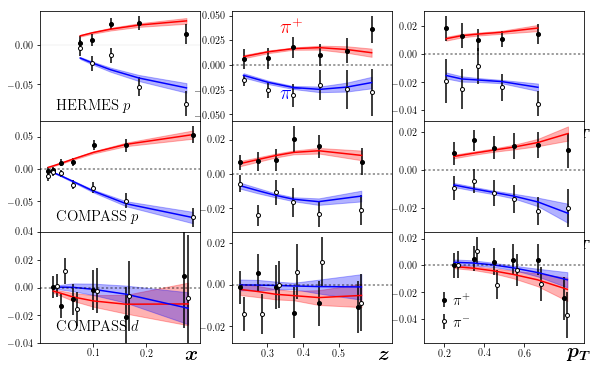

In [229]:
nrows,ncols=3,3
py.figure(figsize=(ncols*3,nrows*2))

ax=plot(1,'x','proton','pi+','HERMES',r'${\rm HERMES}~p$',text=True)
ax=plot(1,'x','proton','pi-','HERMES')
ax.axhline(0,c='k',ls='-',lw=0.1,alpha=0.5)

ax=plot(2,'z','proton','pi+','HERMES')
ax.text(0.3,0.8,r'$\pi^+$',color='r',alpha=1,size=20,transform=ax.transAxes)
ax=plot(2,'z','proton','pi-','HERMES')
ax.text(0.3,0.2,r'$\pi^-$',color='b',alpha=1,size=20,transform=ax.transAxes)
ax.axhline(0,c='k',ls=':',alpha=0.5)

ax=plot(3,'pt','proton','pi+','HERMES')
ax=plot(3,'pt','proton','pi-','HERMES')
ax.axhline(0,c='k',ls=':',alpha=0.5)

ax=plot(4,'x','proton','pi+','COMPASS',r'${\rm COMPASS}~p$',text=True)
ax=plot(4,'x','proton','pi-','COMPASS')
ax.axhline(0,c='k',ls=':',alpha=0.5)

ax=plot(5,'z','proton','pi+','COMPASS')
ax=plot(5,'z','proton','pi-','COMPASS')
ax.axhline(0,c='k',ls=':',alpha=0.5)

ax=plot(6,'pt','proton','pi+','COMPASS')
ax=plot(6,'pt','proton','pi-','COMPASS')
ax.axhline(0,c='k',ls=':',alpha=0.5)

ax=plot(7,'x','deuteron','pi+','COMPASS',r'${\rm COMPASS}~{\huge d}$',text=True,offset2=True)
ax=plot(7,'x','deuteron','pi-','COMPASS',offset=True,offset2=True)
ax.set_yticks([-0.04,-0.02,-0.0,0.02,0.04])
ax.set_ylim(-0.04,0.04)
#ax.set_yticks([-0.04,-0.02,-0.0,0.02,0.04])
ax.axhline(0,c='k',ls=':',alpha=0.5)

ax=plot(8,'z','deuteron','pi+','COMPASS',offset2=True)
ax=plot(8,'z','deuteron','pi-','COMPASS',offset=True,offset2=True)
ax.axhline(0,c='k',ls=':',alpha=0.5)

ax,b,ep=plot(9,'pT','deuteron','pi+','COMPASS',legend=True,offset2=True)
ax,b,em=plot(9,'pT','deuteron','pi-','COMPASS',legend=True,offset=True,offset2=True)
ax.axhline(0,c='k',ls=':',alpha=0.5)
ax.legend([ep,em],[r'$\pi^+$',r'$\pi^-$'],loc=3,frameon=0,fontsize=15,bbox_to_anchor=(-0.05,0), handletextpad=-0.4)

py.subplots_adjust(wspace=0.2, hspace=0,left=0.11, bottom=0.18, right=0.95, top=0.95)
py.savefig('gallery/dvt.pdf')

## PDFs and FFs

In [18]:
def calc(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',run.weights,RAW)
    df=np.einsum('k,kif->if',run.weights,(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

## Transversity

In [19]:
X1=10**np.linspace(-3,-1)
X2=np.linspace(0.101,0.999)
X=np.append(X1,X2)
h1=calc(run1,lambda : [run1.resman.conf['transversity'].get_C(x,1) for x in X],'calc h1')
h2=calc(run2,lambda : [run2.resman.conf['transversity'].get_C(x,1) for x in X],'calc h2')

calc h1 [100%]
calc h2 [100%]


In [20]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hpi1=calc(run1,lambda : [run1.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')
Hpi2=calc(run2,lambda : [run2.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')
#Hk1=calc(run1,lambda : [run1.resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')
Hk2=calc(run2,lambda : [run2.resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')

calc H(pi+) [100%]
calc H(pi+) [100%]
calc H(k+) [100%]


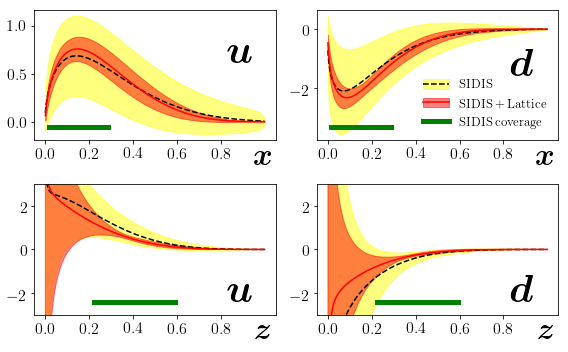

In [92]:
nrows,ncols=2,2
py.figure(figsize=(ncols*4,nrows*2.5))

def plot(idx,flav,legend=False,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(X,(h1['f'][flav]-h1['df'][flav]),(h1['f'][flav]+h1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(X,h1['f'][flav],'k--')
    band2=ax.fill_between(X,(h2['f'][flav]-h2['df'][flav]),(h2['f'][flav]+h2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(X,h2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{x}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    xmin=np.amin(kin['X'])
    xmax=np.amax(kin['X'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    ax.plot([xmin,xmax],[ymin+dy,ymin+dy],'g-',lw=5)
    line,=ax.plot([xmin,xmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax,(band1,line1),(band2,line2),line
 
def plotpi(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(Z,(Hpi1['f'][flav]-Hpi1['df'][flav]),(Hpi1['f'][flav]+Hpi1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(Z,Hpi1['f'][flav],'k--')
    band2=ax.fill_between(Z,(Hpi2['f'][flav]-Hpi2['df'][flav]),(Hpi2['f'][flav]+Hpi2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(Z,Hpi2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax,(band1,line1),(band2,line2),line

def plotk(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(Z,(Hk1['f'][flav]-Hk1['df'][flav]),(Hk1['f'][flav]+Hk1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(Z,Hk1['f'][flav],'k--')
    band2=ax.fill_between(Z,(Hk2['f'][flav]-Hk2['df'][flav]),(Hk2['f'][flav]+Hk2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(Z,Hk2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax

ax,b1,b2,l=plot(1,1)
#ax.set_ylabel(r'$\boldsymbol{h_1^q(x)}$',size=20)
ax.text(0.8,0.6,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax,b1,b2,l=plot(2,3)
ax.text(0.8,0.5,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)
ax.legend([b1,b2,l],[r'$\rm SIDIS$',r'$\rm SIDIS+Lattice$',r'$\rm SIDIS~coverage$']\
    ,fontsize=13,frameon=False,loc=4)#,bbox_to_anchor=(2.2, 1))

#ax=plot(3,5)
#ax.text(0.8,0.1,r'$\boldsymbol{s}$',size=40,transform=ax.transAxes)

ax,b1,b2,l=plotpi(3,1,[-3,3])
#ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~\pi/q}(x)}$',size=20)
ax.text(0.8,0.1,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax,b1,b2,l=plotpi(4,3,[-3,3])
ax.text(0.8,0.1,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

# ax=plotk(7,1,[-0.01,0.1])
# ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~K/q}(x)}$',size=20)
# ax.text(0.8,0.7,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

# ax=plotk(8,3,[-0.1,0.1])
# ax.text(0.4,0.7,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

# ax=plotk(9,6,[-1,1])
# ax.text(0.8,0.7,r'$\boldsymbol{\bar{s}}$',size=40,transform=ax.transAxes)

#py.subplots_adjust(wspace=0.2, hspace=0.3,left=0.1, bottom=0.1, right=0.95, top=0.95)
py.tight_layout()
py.savefig('gallery/transversity-collins.pdf')

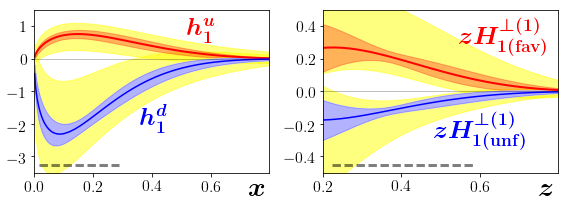

In [232]:
nrows,ncols=1,2
py.figure(figsize=(ncols*4,nrows*3))

def plot(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)

    band1=ax.fill_between(X,(h1['f'][1]-h1['df'][1]),(h1['f'][1]+h1['df'][1]),color='Yellow',alpha=0.5)
    band1=ax.fill_between(X,(h1['f'][3]-h1['df'][3]),(h1['f'][3]+h1['df'][3]),color='Yellow',alpha=0.5)

    #band2=ax.fill_between(X,(h2['f'][1]-h2['df'][1]),(h2['f'][1]+h2['df'][1]),color='w',alpha=1)
    band2=ax.fill_between(X,(h2['f'][1]-h2['df'][1]),(h2['f'][1]+h2['df'][1]),color='r',alpha=0.3)
    line2,=ax.plot(X,h2['f'][1],'r-',lw=2)

    band2=ax.fill_between(X,(h2['f'][3]-h2['df'][3]),(h2['f'][3]+h2['df'][3]),color='w',alpha=1)
    band2=ax.fill_between(X,(h2['f'][3]-h2['df'][3]),(h2['f'][3]+h2['df'][3]),color='b',alpha=0.3)
    line2,=ax.plot(X,h2['f'][3],'b-')

    ax.set_yticks([-3,-2,-1,0,1])


    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{x}$',size=27)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6])
    xmin=np.amin(kin['X'])
    xmax=np.amax(kin['X'])
    ymin, ymax = ax.get_ylim()

    dy=0.05*(ymax-ymin)
    line,=ax.plot([xmin,xmax],[ymin+dy,ymin+dy],'k-',lw=3,alpha=0.5,ls='--')
    return ax,(band1),(band2,line2),line
 
def plotpi(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    
    band1=ax.fill_between(Z,Z*(Hpi1['f'][1]-Hpi1['df'][1]),Z*(Hpi1['f'][1]+Hpi1['df'][1]),color='Yellow',alpha=0.5)
    band1=ax.fill_between(Z,Z*(Hpi1['f'][3]-Hpi1['df'][3]),Z*(Hpi1['f'][3]+Hpi1['df'][3]),color='Yellow',alpha=0.5)
 
    #band2=ax.fill_between(Z,(Hpi2['f'][1]-Hpi2['df'][1]),(Hpi2['f'][1]+Hpi2['df'][1]),color='w')
    band2=ax.fill_between(Z,Z*(Hpi2['f'][1]-Hpi2['df'][1]),Z*(Hpi2['f'][1]+Hpi2['df'][1]),color='r',alpha=0.3)
    line2,=ax.plot(Z,Z*Hpi2['f'][1],'r-',lw=2)

    band2=ax.fill_between(Z,Z*(Hpi2['f'][3]-Hpi2['df'][3]),Z*(Hpi2['f'][3]+Hpi2['df'][3]),color='w')
    band2=ax.fill_between(Z,Z*(Hpi2['f'][3]-Hpi2['df'][flav]),Z*(Hpi2['f'][3]+Hpi2['df'][3]),color='b',alpha=0.3)
    line2,=ax.plot(Z,Z*Hpi2['f'][3],'b-')


    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=27)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.05*(ymax-ymin)
    line,=ax.plot([zmin,zmax*0.99],[ymin+dy,ymin+dy],'k-',ls='--',lw=3,alpha=0.5)
    return ax,(band1),(band2,line2),line

ax,b1,b2,l=plot(1,1,[-3.5,1.5])
ax.text(0.65,0.8,r'$\boldsymbol{h_1^u}$',size=25,transform=ax.transAxes,color='r')
ax.text(0.45,0.25,r'$\boldsymbol{h_1^d}$',size=25,transform=ax.transAxes,color='b')

ax.set_xlim(0,0.8)
ax.axhline(0,ls='-',lw=0.5,color='k',alpha=0.5)

ax,b1,b2,l=plotpi(2,2,[-0.5,0.5])
ax.text(0.58,0.75,r'$\boldsymbol{zH_{1 {\rm (fav)}}^{\perp (1)}}$',size=25,transform=ax.transAxes,color='r')
ax.text(0.47,0.17,r'$\boldsymbol{zH_{1 {\rm (unf)}}^{\perp (1)}}$',size=25,transform=ax.transAxes,color='b')
ax.set_xlim(0.2,0.8)
ax.axhline(0,ls='-',lw=0.5,color='k',alpha=0.5)
ax.set_yticks([-0.4,-0.2,0,0.2,0.4])

#ax.legend([b1,b2,l],[r'$\rm SIDIS$',r'$\rm SIDIS+Lattice$',r'$\rm SIDIS~coverage$']\
#    ,fontsize=13,frameon=False,loc=4)#,bbox_to_anchor=(2.2, 1))

py.tight_layout()
py.savefig('gallery/transversity-collins.pdf')

## gT

In [22]:
def calc2(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    return RAW

gT1=calc2(run1,lambda : run1.moments.get_gT(),'calc gT1')
gT2=calc2(run2,lambda : run2.moments.get_gT(),'calc gT2')

uv1=calc2(run1,lambda : run1.moments.get_flav('uv'),'calc uv1')
dv1=calc2(run1,lambda : run1.moments.get_flav('dv'),'calc dv1')
uv2=calc2(run2,lambda : run2.moments.get_flav('uv'),'calc uv2')
dv2=calc2(run2,lambda : run2.moments.get_flav('dv'),'calc dv2')


calc gT1 [100%]
calc gT2 [100%]
calc uv1 [100%]
calc dv1 [100%]
calc uv2 [100%]
calc dv2 [100%]


In [254]:
Euv1 = np.einsum('k,k',uv1,run1.weights)
Suv1 = np.einsum('k,k',(uv1-Euv1)**2,run1.weights)**0.5
Euv2 = np.einsum('k,k',uv2,run2.weights)
Suv2 = np.einsum('k,k',(uv2-Euv2)**2,run2.weights)**0.5

Edv1 = np.einsum('k,k',dv1,run1.weights)
Sdv1 = np.einsum('k,k',(dv1-Edv1)**2,run1.weights)**0.5
Edv2 = np.einsum('k,k',dv2,run2.weights)
Sdv2 = np.einsum('k,k',(dv2-Edv2)**2,run2.weights)**0.5

print 'uv1=%10.1f +/- %10.1f'%(Euv1,Suv1)
print 'uv2=%10.2f +/- %10.2f'%(Euv2,Suv2)
print 'dv1=%10.1f +/- %10.1f'%(Edv1,Sdv1)
print 'dv2=%10.2f +/- %10.2f'%(Edv2,Sdv2)

uv1=       0.3 +/-        0.3
uv2=      0.29 +/-       0.15
dv1=      -0.6 +/-        0.5
dv2=     -0.72 +/-       0.16


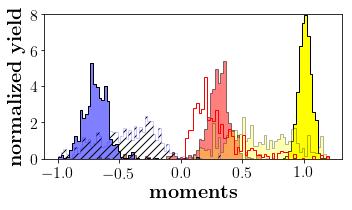

In [275]:
nrows,ncols=1,1
py.figure(figsize=(ncols*5,nrows*3))

ax=py.subplot(nrows,ncols,1)
R=(-1.,1.2)
bins=100


ax.hist(gT2,histtype='stepfilled',range=R\
    ,weights=run2.weights,bins=bins\
    ,facecolor='Yellow',edgecolor='k'
    ,label=r'$\rm g_T~(SIDIS+Lattice)$',normed=True)

ax.hist(uv2,histtype='stepfilled',range=R\
    ,weights=run2.weights,bins=bins\
    ,facecolor='r',edgecolor='k',alpha=0.5\
    ,label=r'$\rm \delta u~(SIDIS+Lattice)$',normed=True)

ax.hist(dv2,histtype='stepfilled',range=R\
    ,weights=run2.weights,bins=bins\
    ,facecolor='b',edgecolor='k',alpha=0.5\
    ,label=r'$\rm \delta d~(SIDIS+Lattice)$',normed=True)
ax.hist(dv2,histtype='stepfilled',range=R\
    ,weights=run2.weights,bins=bins,facecolor='none',edgecolor='k',normed=True)



ax.hist(gT1,histtype='stepfilled',range=R\
   ,weights=run1.weights,bins=bins,facecolor='Yellow',edgecolor='k',alpha=0.3#,hatch='....'\
   ,label=r'$\rm g_T~(SIDIS)$',normed=True)

ax.hist(uv1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=bins\
    ,facecolor='none',edgecolor='r'#,hatch='...'\
    ,label=r'$\rm \delta u~(SIDIS)$',normed=True)

ax.hist(dv1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=bins,facecolor='none',edgecolor='b',alpha=0.2,hatch='///'\
    ,label=r'$\rm \delta d~(SIDIS)$',normed=True)

ax.set_ylabel(r'$\boldsymbol{\rm normalized~yield}$',size=20)
ax.set_xlabel(r'$\boldsymbol{\rm moments}$',size=20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_xticks([0,.2,.4,.6,.8,1])
ax.set_ylim(0,8)
#ax.legend(frameon=False,fontsize=10,loc=2,ncol=2)
py.tight_layout()
py.savefig('gallery/ud.pdf')

In [268]:
def unweight(uv,dv,weights):
    wmax=np.amax(weights)
    wcut=wmax*3e-4
    uvc=[uv[i] for i in range(weights.size) if weights[i]>wcut]
    dvc=[uv[i] for i in range(weights.size) if weights[i]>wcut]
    weightsc=np.array([weights[i] for i in range(weights.size) if weights[i]>wcut])
    weightsc/=np.sum(weightsc)
    
    
    wmin=np.amin(weightsc)
    N=int(1/wmin)
    _uv,_dv=[],[]
    npts=0
    for i in range(len(weightsc)):
        npts+=int(N*weightsc[i])
        _uv.extend([uv[i]]*int(N*weights[i]))
        _dv.extend([dv[i]]*int(N*weights[i]))
    print npts
    return _uv,_dv
_uv1,_dv1=unweight(uv1,dv1,run1.weights)
_uv2,_dv2=unweight(uv2,dv2,run2.weights)

827051
709265


In [235]:
import seaborn as sns
#from mpl_toolkits.axes_grid.inset_locator import inset_axes

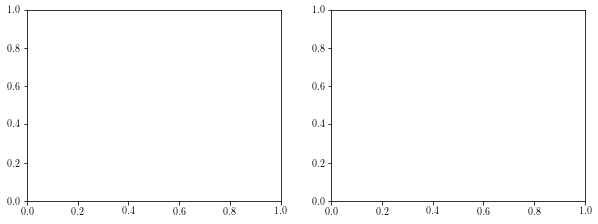

In [277]:
nrows,ncols=1,2
fig, ax=py.subplots(nrows=nrows, ncols=ncols,figsize=(ncols*5,nrows*3.5))

In [290]:
ax[0].clear()
sns.kdeplot(_uv1,_dv1, shade=True,shade_lowest=False,cmap="YlGn",ax=ax[0])
sns.kdeplot(_uv2,_dv2, shade=True,shade_lowest=False,cmap="Reds",ax=ax[0])

In [281]:
toRGB=lambda p: (float(p[0])/255,float(p[1])/255,float(p[2])/255)
ax[1].clear()
R=(0,1.5)
bins=30
ax[1].hist(gT1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=bins\
    ,facecolor="Yellow",edgecolor='none',alpha=0.5\
    ,label=r'$\rm SIDIS$',normed=True);
ax[1].hist(gT1,histtype='step',range=R\
    ,weights=run1.weights,bins=bins\
    ,facecolor="none",edgecolor='k',alpha=1\
    ,label=r'$\rm SIDIS$',normed=True);


ax[1].hist(gT2,histtype='stepfilled',range=R\
   ,weights=run2.weights,bins=bins,facecolor='w',normed=True);
ax[1].hist(gT2,histtype='stepfilled',range=R\
   ,weights=run2.weights,bins=bins,facecolor=toRGB((251,105,74))\
    #,edgecolor='r',hatch='...'\
   ,label=r'$\rm SIDIS+Lattice$',normed=True,alpha=1);

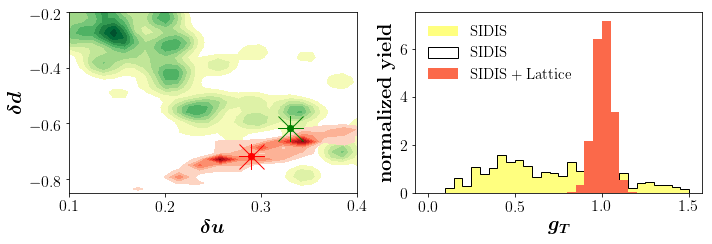

In [299]:
ax[0].set_xlim(0.1,0.4)
ax[0].set_ylim(-0.85,-0.2)
ax[0].set_ylabel(r'$\boldsymbol{\delta d}$',size=20)
ax[0].set_xlabel(r'$\boldsymbol{\delta u}$',size=20)
ax[0].tick_params(axis='both', which='major', labelsize=16)

#ax[0].errorbar([Euv1],[Edv1],xerr=Suv1,yerr=Sdv1,fmt='g.')
#ax[0].errorbar([Euv2],[Edv2],xerr=Suv2,yerr=Sdv2,fmt='r.')
ax[0].plot([Euv1],[Edv1],'g+',markersize=25)
ax[0].plot([Euv2],[Edv2],'r+',markersize=25)



ax[1].set_ylabel(r'$\boldsymbol{\rm normalized~yield}$',size=20)
ax[1].set_xlabel(r'$\boldsymbol{g_T}$',size=20)
ax[1].tick_params(axis='both', which='major', labelsize=16)

#ax.set_xticks([0,.2,.4,.6,.8,1])
ax[1].legend(frameon=False,fontsize=15,loc=2)
fig.tight_layout()
fig.savefig('gallery/gT.pdf')
fig